# 👖 Variational Autoencoders - Fashion-MNIST

Отличие от автокодировщика в том, что здесь изображение отображается в многомерное нормальное распределение вокруг точки в скрытом пространстве. Это уменьшает потери при реконструкции, т.к. мы выбираем случайную точку вокруг z_mean(среднего значения), т.е. само пространство становится непреревным .

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32 #размер картинок
BATCH_SIZE = 100 
VALIDATION_SPLIT = 0.2 
EMBEDDING_DIM = 2 #размерность выходного вектора кодировщика (скрытое пространство)
EPOCHS = 5
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

## 2. Build the variational autoencoder <a name="build"></a>

In [6]:
#создаем кастомный слой, который будет делать выборку из нормального распределения с параметрами z_mean, z_log_var
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) #трюк с параметризацией, берем епсилон из стандартного нормального распределения
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
#подключаем слой Flatten к слоям z_mean и z_log_var
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
#слой z выбирает точку в скрытом пространстве из нормального распределения с параметрами z_mean,z_log_var
z = Sampling()([z_mean, z_log_var])

#на выходе кодировщика: точка z и параметры z_mean,z_log_var
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [9]:
# Decoder
#декодор ничем не отличаеся от варианта автокодировщика
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

В функцию потерь необходимо добавить расстояние Кульбака-Лейблера: оно измеряет насколько одно распределение вероятности отличается от другого. В нашем вариационном автокодировщике важно знать насколько наше распределение с параметрами z_mean,z_log_var отличается от стандартного нормального распределения. С такой поправкой кодировщик будет использовать пространство вокруг источника максимально симметрично и эффективно.

In [10]:
#создаем класс вариационного автокодировщика
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs): 
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data): #шаг обучения VAE включая вычисление функции потерь
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA #коэффициент взвешивания расстояния KL, чтобы ругелировать сбалансированность (тут берем 500)
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss #общая велечина потерь 

        grads = tape.gradient(total_loss, self.trainable_weights) #градиентная лента 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [13]:
# Create a model save checkpoint
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath="./checkpoint",
#     save_weights_only=False,
#     save_freq="epoch",
#     monitor="loss",
#     mode="min",
#     save_best_only=True,
#     verbose=0,
# )
# tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [14]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)
#callbacks=[model_checkpoint_callback, tensorboard_callback],


Epoch 1/5
600/600 [==============================] - 33s 52ms/step - total_loss: 162.8848 - reconstruction_loss: 158.5107 - kl_loss: 4.3740 - val_loss: 141.3432 - val_reconstruction_loss: 136.3009 - val_kl_loss: 5.0423
Epoch 2/5
600/600 [==============================] - 30s 50ms/step - total_loss: 135.8036 - reconstruction_loss: 130.8217 - kl_loss: 4.9819 - val_loss: 137.5102 - val_reconstruction_loss: 132.5722 - val_kl_loss: 4.9380
Epoch 3/5
600/600 [==============================] - 30s 51ms/step - total_loss: 134.0481 - reconstruction_loss: 129.0218 - kl_loss: 5.0262 - val_loss: 135.8974 - val_reconstruction_loss: 130.7876 - val_kl_loss: 5.1098
Epoch 4/5
600/600 [==============================] - 31s 51ms/step - total_loss: 133.1192 - reconstruction_loss: 128.0392 - kl_loss: 5.0801 - val_loss: 135.4542 - val_reconstruction_loss: 130.2856 - val_kl_loss: 5.1686
Epoch 5/5
600/600 [==============================] - 30s 50ms/step - total_loss: 132.5281 - reconstruction_loss: 127.4137 - 

In [ ]:
# Save the final models
# vae.save("./models/vae")
# encoder.save("./models/encoder")
# decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [15]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 1s 7ms/step


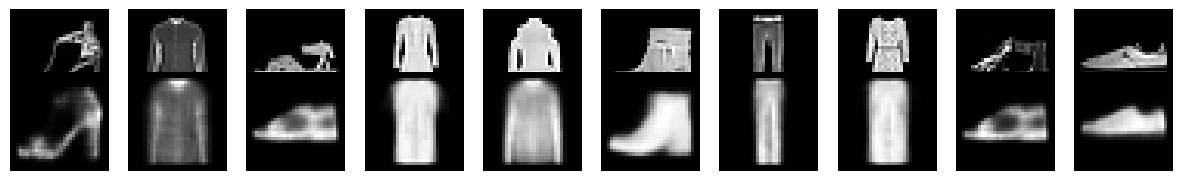

In [22]:
#визуализируем данные с их предсказаниями
n_to_show = 10
#берем 5 случайный картинок
indices = np.random.choice(range(len(x_test[:n_to_predict])), n_to_show)
fig = plt.figure(figsize=(15, 3))

#оригинальные и созданные картинки
for i, idx in enumerate(indices):
    img_orig = x_test[idx]
    img_pred = reconstructions[idx]
    ax = fig.add_subplot(2, n_to_show, i + 1)
    ax.axis("off")
    ax.imshow(img_orig, cmap='gray')

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.imshow(img_pred, cmap='gray')

## 4. Embed using the encoder <a name="encode"></a>

In [23]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 3ms/step


In [24]:
# Some examples of the embeddings
print(z[:5])

[[-1.6453238  -0.50683093]
 [-0.12189084  0.7120801 ]
 [ 2.1819196   1.4959564 ]
 [ 2.482617   -0.14329532]
 [ 0.201804   -0.21365651]]


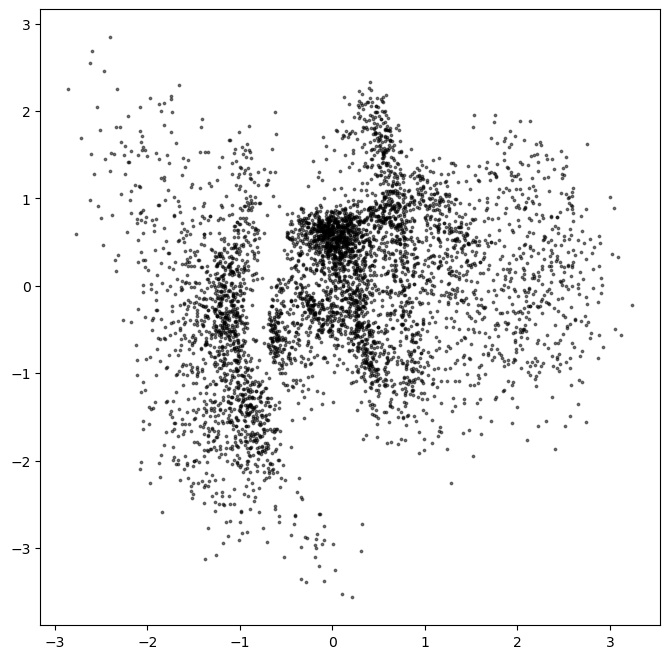

In [25]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [26]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [27]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 112ms/step


In [28]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

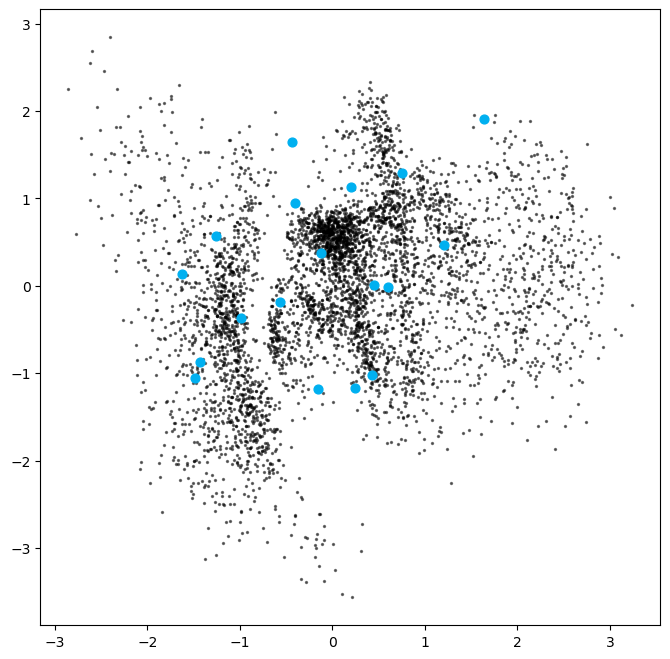

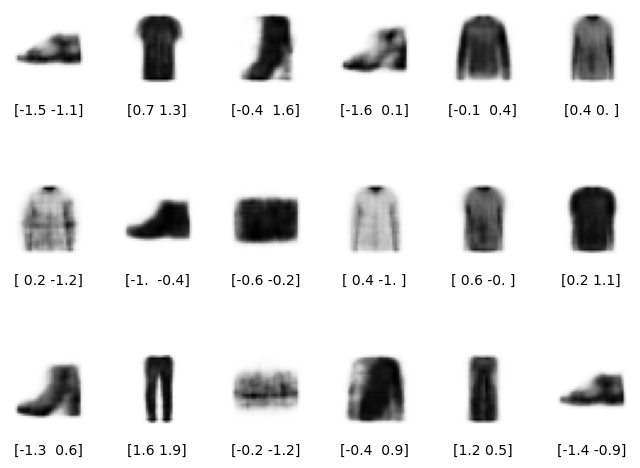

In [29]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

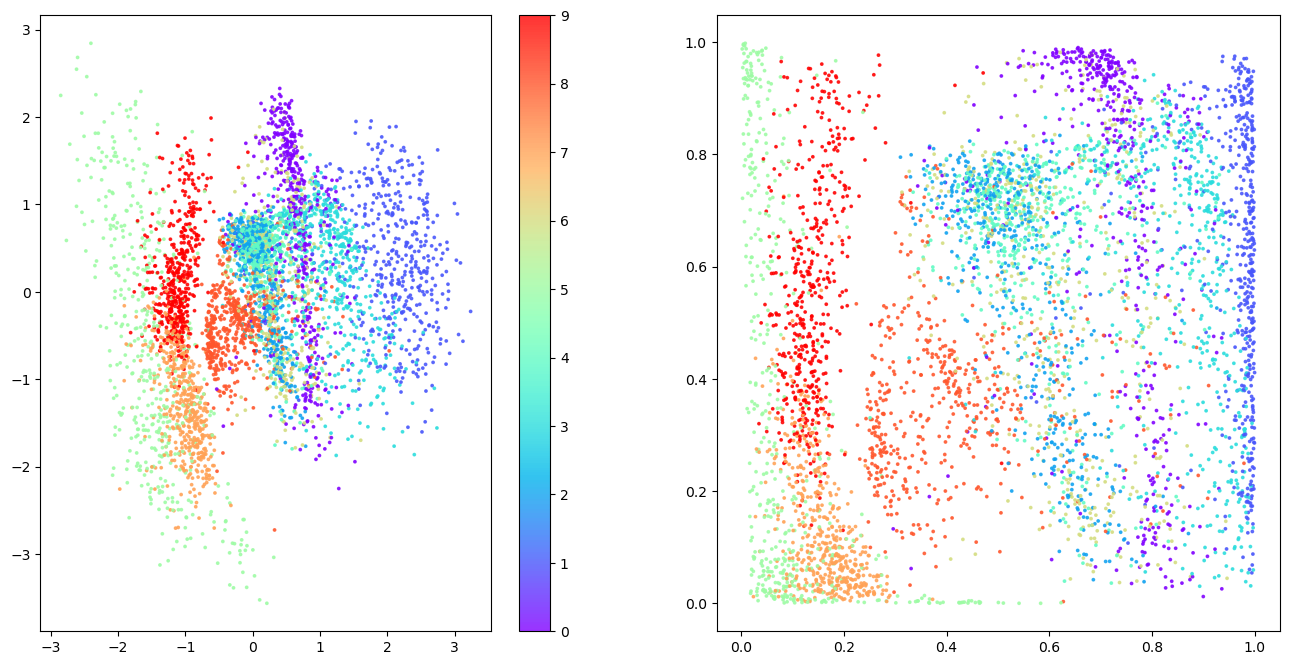

In [30]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 7ms/step


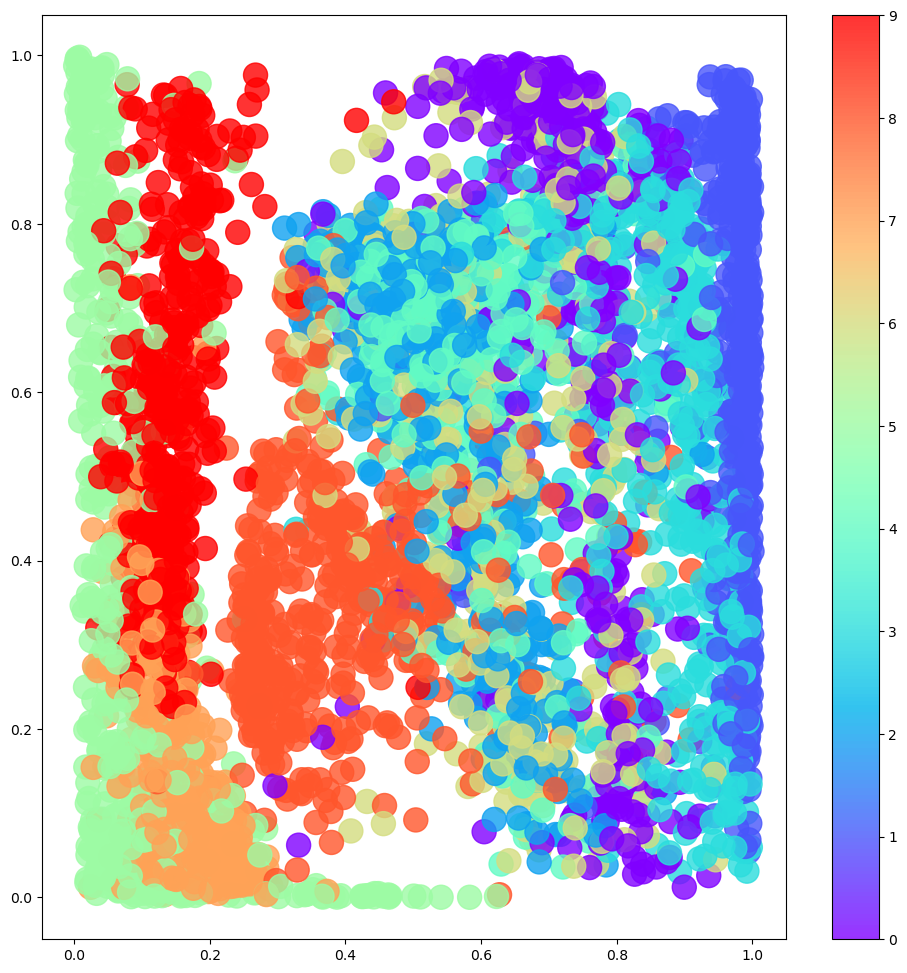

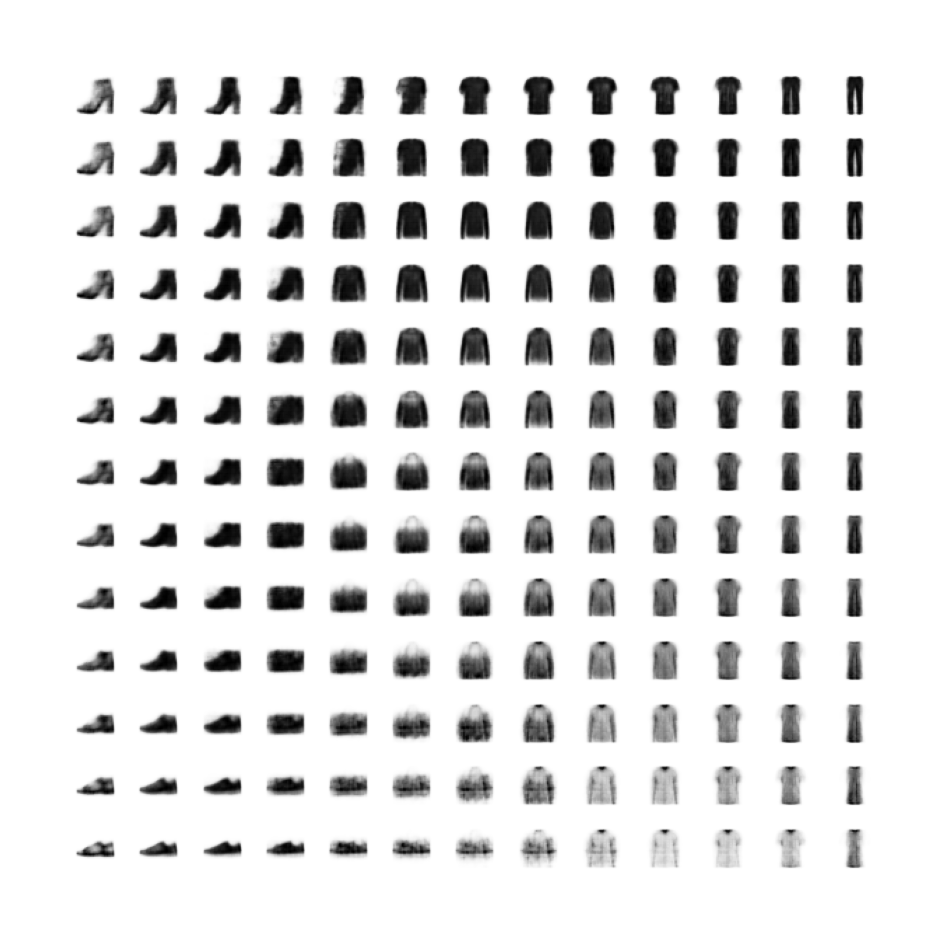

In [31]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")